Transfer Learning using Deberta-V3 for Labelling

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import optuna
from datasets import Dataset
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

Preprocessing

In [ ]:
# Load dataset
file_path = "2_processed_data/sampling_labelled.csv"
df = pd.read_csv(file_path, encoding="latin1")

valid = ['C', 'G', 'W/Q', 'OTH']
df = df[df['argument_type'].isin(valid)].copy()

df['input'] = df['sentence']
label_map = {label: idx for idx, label in enumerate(valid)}
inv_label_map = {idx: label for label, idx in label_map.items()}
df['label'] = df['argument_type'].map(label_map).astype(int)

In [ ]:
# Stratified Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['input'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [ ]:
# Tokenizer and Model
model_ckpt = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(valid)
)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenization
train_enc = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_enc = tokenizer(val_texts, truncation=True, padding=True, max_length=256)
train_dataset = Dataset.from_dict({
    'input_ids': train_enc['input_ids'],
    'attention_mask': train_enc['attention_mask'],
    'labels': train_labels
})
val_dataset = Dataset.from_dict({
    'input_ids': val_enc['input_ids'],
    'attention_mask': val_enc['attention_mask'],
    'labels': val_labels
})

Modelling

In [ ]:
# Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

In [ ]:
# Training Configuration
training_args = TrainingArguments(
    output_dir='logging/transfer_learning/results',
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.05,
    num_train_epochs=4,
    logging_dir='logging/transfer_learning/logs',
    logging_steps=10,
    save_total_limit=2,
    fp16=torch.cuda.is_available()
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# Train
trainer.train()

C:\Users\user\AppData\Local\Temp\ipykernel_148840\1318337750.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.779200,0.689263,0.721578,0.578416
2,0.616600,0.632985,0.758701,0.710089
3,0.436200,0.623759,0.783063,0.719801
4,0.241000,0.687445,0.788863,0.729301


TrainOutput(global_step=864, training_loss=0.5796680402148653, metrics={'train_runtime': 1639.9734, 'train_samples_per_second': 8.403, 'train_steps_per_second': 0.527, 'total_flos': 757735645499040.0, 'train_loss': 0.5796680402148653, 'epoch': 4.0})

Model Evaluation

In [ ]:
# Final evaluation
preds = trainer.predict(val_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print("\n=== Classification Report ===")
labels_present = sorted(set(val_labels))
target_names_present = [inv_label_map[i] for i in labels_present]

print(classification_report(
    val_labels,
    y_pred,
    labels=labels_present,
    target_names=target_names_present,
    zero_division=0
))


=== Classification Report ===
              precision    recall  f1-score   support

           C       0.77      0.84      0.81       184
           G       0.83      0.79      0.81       255
         W/Q       0.80      0.86      0.83       339
         OTH       0.60      0.39      0.47        84

    accuracy                           0.79       862
   macro avg       0.75      0.72      0.73       862
weighted avg       0.78      0.79      0.78       862



Confusion Matrix:
 [[155   5  21   3]
 [ 15 201  28  11]
 [ 21  19 291   8]
 [ 10  16  25  33]]


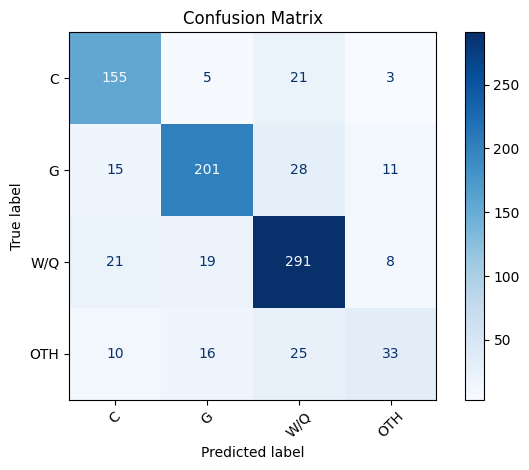

In [ ]:
# True labels
y_true = val_labels

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['C', 'G', 'W/Q', 'OTH']

# Print numeric matrix
print("Confusion Matrix:\n", cm)

# Display as heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# Save
model.save_pretrained("3_model/transfer-learning/deberta-v3-final")
tokenizer.save_pretrained("3_model/transfer-learning/deberta-v3-final")

('deberta-v3-4class-final\\tokenizer_config.json',
 'deberta-v3-4class-final\\special_tokens_map.json',
 'deberta-v3-4class-final\\spm.model',
 'deberta-v3-4class-final\\added_tokens.json',
 'deberta-v3-4class-final\\tokenizer.json')

Hyperparameter Tuning

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=len(valid)
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

# Define search space for hyperparameter tuning
def model_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 6),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
    }

# Trainer setup for hyperparameter search
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# Launch Optuna search
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=model_hp_space,
    n_trials=10,
    compute_objective=lambda metrics: metrics["eval_f1_macro"]
)

# Show best results
print("\n=== Best Hyperparameters ===")
print(best_trial)


C:\Users\user\AppData\Local\Temp\ipykernel_148840\3955521817.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-04 00:51:51,012] A new study created in memory with name: no-name-bc46185d-430d-4cf7-b3cf-765ecc8a890b
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to u

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.326300,1.266893,0.401392,0.234924
2,0.680900,0.748150,0.720418,0.576867
3,0.534400,0.596814,0.749420,0.689128
4,0.458100,0.548737,0.785383,0.709831
5,0.520600,0.487474,0.801624,0.734096
6,0.326200,0.588001,0.802784,0.735488


[I 2025-08-04 01:54:54,179] Trial 0 finished with value: 0.7354882623182144 and parameters: {'learning_rate': 3.2745153492282726e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 8, 'weight_decay': 0.23593844945310521}. Best is trial 0 with value: 0.7354882623182144.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.209800,1.119253,0.556845,0.436614
2,0.879400,0.820895,0.679814,0.544950
3,0.803100,0.716809,0.716937,0.573073
4,0.566300,0.718349,0.719258,0.573651
5,0.670500,0.714412,0.719258,0.573768


[I 2025-08-04 03:07:02,269] Trial 1 finished with value: 0.5737677489557891 and parameters: {'learning_rate': 4.223422331907941e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.015494099881340017}. Best is trial 0 with value: 0.7354882623182144.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.309700,1.257885,0.402552,0.180790
2,1.252000,1.157353,0.529002,0.392104
3,1.097100,1.055148,0.588167,0.457890
4,0.979200,0.994976,0.624130,0.497730
5,1.004900,0.975462,0.626450,0.502011


[I 2025-08-04 04:51:09,703] Trial 2 finished with value: 0.5020108869740878 and parameters: {'learning_rate': 1.2125165897180063e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.2481955429561857}. Best is trial 0 with value: 0.7354882623182144.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.376600,1.359608,0.393271,0.141132
2,1.333500,1.335018,0.393271,0.141132


[I 2025-08-04 05:16:25,930] Trial 3 finished with value: 0.14113238967527061 and parameters: {'learning_rate': 1.3904400779784472e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'weight_decay': 0.17806027493247598}. Best is trial 0 with value: 0.7354882623182144.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.600800,0.637932,0.737819,0.656048
2,0.477200,0.561824,0.795824,0.747749
3,0.353900,0.546056,0.801624,0.732993
4,0.187500,0.698607,0.806265,0.747360


[I 2025-08-04 06:25:07,052] Trial 4 finished with value: 0.7473599632727226 and parameters: {'learning_rate': 2.3663473935914246e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'weight_decay': 0.25923895271931247}. Best is trial 4 with value: 0.7473599632727226.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.332400,1.313578,0.393271,0.141132
2,1.263500,1.243081,0.406032,0.168261


[I 2025-08-04 06:54:36,788] Trial 5 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.058200,0.984050,0.633411,0.499876
2,0.706800,0.685285,0.728538,0.584151
3,0.646600,0.667214,0.762181,0.680821
4,0.483800,0.679354,0.761021,0.684846


[I 2025-08-04 07:57:38,429] Trial 6 finished with value: 0.6848458891472275 and parameters: {'learning_rate': 1.1848780523825906e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'weight_decay': 0.14483143503637233}. Best is trial 4 with value: 0.7473599632727226.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.529800,0.626786,0.743619,0.663696
2,0.469400,0.559088,0.791183,0.736341
3,0.336500,0.692243,0.795824,0.735425
4,0.196200,0.787188,0.792343,0.734610


[I 2025-08-04 08:32:53,626] Trial 7 finished with value: 0.7346095129188831 and parameters: {'learning_rate': 1.550400740110495e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'weight_decay': 0.18981141870961044}. Best is trial 4 with value: 0.7473599632727226.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.688900,0.644186,0.750580,0.614796
2,0.479800,0.678543,0.744780,0.692015
3,0.369600,0.603595,0.796984,0.732453
4,0.238700,0.584058,0.801624,0.747633
5,0.141800,0.690949,0.810905,0.752443
6,0.137000,0.795787,0.808585,0.741869


[I 2025-08-04 10:54:08,773] Trial 8 finished with value: 0.7418685510028137 and parameters: {'learning_rate': 3.3700298048421046e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.006697343423590007}. Best is trial 4 with value: 0.7473599632727226.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.252300,1.246460,0.416473,0.204980


[I 2025-08-04 11:07:00,910] Trial 9 pruned. 



=== Best Hyperparameters ===
BestRun(run_id='4', objective=0.7473599632727226, hyperparameters={'learning_rate': 2.3663473935914246e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'weight_decay': 0.25923895271931247}, run_summary=None)


AttributeError: 'TrainingArguments' object has no attribute 'clone'

In [ ]:
best_params = {
    'learning_rate': 2.3663473935914246e-05,
    'num_train_epochs': 4,
    'per_device_train_batch_size': 8,
    'weight_decay': 0.25923895271931247
}

best_training_args = TrainingArguments(
    output_dir='logging/transfer_learning/best_run',
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    learning_rate=best_params['learning_rate'],
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=16,  # Can remain fixed
    weight_decay=best_params['weight_decay'],
    logging_dir='logging/transfer_learning/logs_best',
    logging_steps=10,
    save_total_limit=2,
    fp16=torch.cuda.is_available()
)

# Reinitialize model with same architecture
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(valid)
)

# Define Trainer with best hyperparameters
best_trainer = Trainer(
    model=model,
    args=best_training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

best_trainer.train()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_148840\1328664253.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.546600,0.656864,0.730858,0.610144
2,0.521100,0.523691,0.806265,0.752300
3,0.307900,0.551608,0.820186,0.766877
4,0.089700,0.746809,0.821346,0.759881


TrainOutput(global_step=1724, training_loss=0.508991288889865, metrics={'train_runtime': 908.1845, 'train_samples_per_second': 15.173, 'train_steps_per_second': 1.898, 'total_flos': 757735645499040.0, 'train_loss': 0.508991288889865, 'epoch': 4.0})


=== Classification Report ===
              precision    recall  f1-score   support

           C       0.88      0.85      0.87       184
           G       0.83      0.83      0.83       255
         W/Q       0.85      0.88      0.86       339
         OTH       0.51      0.50      0.51        84

    accuracy                           0.82       862
   macro avg       0.77      0.76      0.77       862
weighted avg       0.82      0.82      0.82       862

Confusion Matrix:
 [[157   5  15   7]
 [  6 211  21  17]
 [  7  19 297  16]
 [  8  18  16  42]]


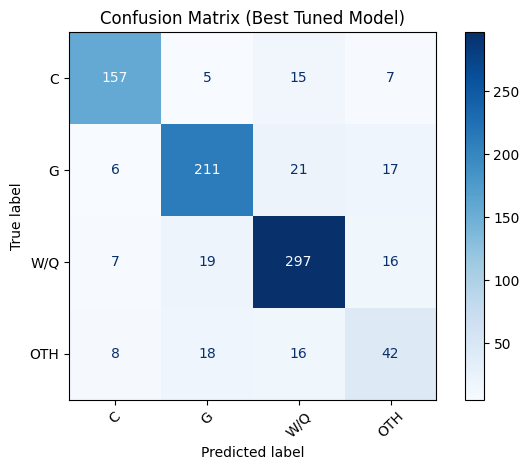


Best tuned model saved to: deberta-v3-4class-tuned-final


In [ ]:
# Final predictions and evaluation
preds = best_trainer.predict(val_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = val_labels

# Classification report
print("\n=== Classification Report ===")
print(classification_report(
    y_true,
    y_pred,
    labels=sorted(set(y_true)),
    target_names=[inv_label_map[i] for i in sorted(set(y_true))],
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['C', 'G', 'W/Q', 'OTH'])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (Best Tuned Model)")
plt.tight_layout()
plt.show()

# Save final model and tokenizer
save_path = "3_model/transfer-learning/deberta-v3-tuned-final"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\nBest tuned model saved to: {save_path}")